In [36]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pyexr
import matplotlib.pyplot as plt
import os

import tensorflow as tf
from Model import *

In [33]:
shading_net = ShadingNet(weights_dir='../models/model_2018-09-22 12:25:23.132954.h5')
shading_net.trainable=False

compositor_net = ScaleWeightPredictor()

input_image = keras.Input(shape=(512, 512, 6))
down_level_1 = keras.layers.AveragePooling2D()(input_image)
down_level_2 = keras.layers.AveragePooling2D()(down_level_1)

shading_level_0 = shading_net(input_image)
shading_level_1 = shading_net(down_level_1)
shading_level_2 = shading_net(down_level_2)

shading_level_2_up = keras.layers.UpSampling2D(size=(2, 2))(shading_level_2)
compositor_1 = compositor_net([shading_level_1, shading_level_2_up])
compositor_0 = keras.layers.UpSampling2D(size=(2, 2))(compositor_1)
final = compositor_net([shading_level_0, compositor_0])

model = keras.Model(input_image, final)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_33 (InputLayer)           (None, 512, 512, 6)  0                                            
__________________________________________________________________________________________________
average_pooling2d_14 (AveragePo (None, 256, 256, 6)  0           input_33[0][0]                   
__________________________________________________________________________________________________
average_pooling2d_15 (AveragePo (None, 128, 128, 6)  0           average_pooling2d_14[0][0]       
__________________________________________________________________________________________________
model_22 (Model)                multiple             2378977     input_33[0][0]                   
                                                                 average_pooling2d_14[0][0]       
          

In [34]:
model.load_weights('../models/model_multiscale_2018-10-09 18:08:05.192028.h5')

In [64]:
intermediate_layer_model = keras.Model(inputs=model.input,
                                 outputs=model.get_layer('average_pooling2d_14').output)

TESTDATA_DIR = '/media/marcelsantos/StorageDevice/DeepShadingTestImages'
VALIDATIONDATA_DIR = '/media/marcelsantos/StorageDevice/DeepShadingValidationImages'
FILE_NAME = '0000000004.exr'
OUTPUT_NAME = 'Sibenik' + FILE_NAME

# Evaluate loaded model on test data.
normal_image = pyexr.read_all(VALIDATIONDATA_DIR + '/Sibenik/Normals/' + FILE_NAME)['default'][:,:,0:3]
position_image = pyexr.read_all(VALIDATIONDATA_DIR + '/Sibenik/Position/'+ FILE_NAME)['default'][:,:,0:3]
input_image = np.dstack([normal_image, position_image])

batch = np.expand_dims(input_image, axis=0)
intermediate_output = intermediate_layer_model.predict(batch)
result = intermediate_output[0,:,:,3:6] 

In [65]:
result.shape

(256, 256, 3)

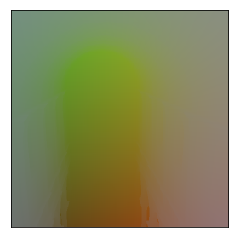

In [66]:
plt.xticks([])
plt.yticks([])
plt.imshow(result, cmap='gray')
plt.show()